# XMM-LSS master catalogue

This notebook presents the merge of the pristine catalogues from CFHT Megacam. This has to be conducted separately on XMM-LSS due to the large amount of memory required on this field.

This notebook also ingests all the CANDELS-UDS data apart from the photometry that needs to be merged in other 2.x notebooks.

Since this is where we ingest all the CANDELS fluxes apert from UKIDSS and IRAC we take the opportunity here to merge them in with SXDS Suprime fluxes.



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]
This notebook was executed on: 
2018-02-19 14:17:41.586755


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
#candels = Table.read("{}/CANDELS.fits".format(TMP_DIR))           # 1.1
candels = Table.read("{}/CANDELS-UDS.fits".format(TMP_DIR))           # 1.2
cfht_wirds = Table.read("{}/CFHT-WIRDS.fits".format(TMP_DIR))     # 1.3
cfhtls_wide = Table.read("{}/CFHTLS-WIDE.fits".format(TMP_DIR))   # 1.4a
cfhtls_deep = Table.read("{}/CFHTLS-DEEP.fits".format(TMP_DIR))   # 1.4b
#We no longer use CFHTLenS as it is the same raw data set as CFHTLS-WIDE
# cfhtlens = Table.read("{}/CFHTLENS.fits".format(TMP_DIR))         # 1.5
#decals = Table.read("{}/DECaLS.fits".format(TMP_DIR))             # 1.6
#servs = Table.read("{}/SERVS.fits".format(TMP_DIR))               # 1.8
#swire = Table.read("{}/SWIRE.fits".format(TMP_DIR))               # 1.7
#hsc_wide = Table.read("{}/HSC-WIDE.fits".format(TMP_DIR))         # 1.9a
#hsc_deep = Table.read("{}/HSC-DEEP.fits".format(TMP_DIR))         # 1.9b
#hsc_udeep = Table.read("{}/HSC-UDEEP.fits".format(TMP_DIR))       # 1.9c
#ps1 = Table.read("{}/PS1.fits".format(TMP_DIR))                   # 1.10
sxds = Table.read("{}/SXDS.fits".format(TMP_DIR))                 # 1.11
sparcs = Table.read("{}/SpARCS.fits".format(TMP_DIR))             # 1.12
#dxs = Table.read("{}/UKIDSS-DXS.fits".format(TMP_DIR))            # 1.13
#uds = Table.read("{}/UKIDSS-UDS.fits".format(TMP_DIR))            # 1.14
vipers = Table.read("{}/VIPERS.fits".format(TMP_DIR))             # 1.15
#vhs = Table.read("{}/VISTA-VHS.fits".format(TMP_DIR))             # 1.16
#video = Table.read("{}/VISTA-VIDEO.fits".format(TMP_DIR))         # 1.17
#viking = Table.read("{}/VISTA-VIKING.fits".format(TMP_DIR))       # 1.18

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones. We start with PanSTARRS because it coevrs the whole field.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### Start with CANDELS

In [5]:
master_catalogue = candels
master_catalogue['candels_ra'].name = 'ra'
master_catalogue['candels_dec'].name = 'dec'
del candels
unused_bands = [ 'candels-ukidss', 'candels-irac']
for col in master_catalogue.colnames:
    
    for band in unused_bands:
        if band in col:
            master_catalogue.remove_column(col)
            print(col, ' removed.')

f_candels-ukidss_j  removed.
ferr_candels-ukidss_j  removed.
f_candels-ukidss_h  removed.
ferr_candels-ukidss_h  removed.
f_candels-ukidss_k  removed.
ferr_candels-ukidss_k  removed.
f_candels-irac_i1  removed.
ferr_candels-irac_i1  removed.
f_candels-irac_i2  removed.
ferr_candels-irac_i2  removed.
f_candels-irac_i3  removed.
ferr_candels-irac_i3  removed.
f_candels-irac_i4  removed.
ferr_candels-irac_i4  removed.
m_candels-ukidss_j  removed.
merr_candels-ukidss_j  removed.
flag_candels-ukidss_j  removed.
m_candels-ukidss_h  removed.
merr_candels-ukidss_h  removed.
flag_candels-ukidss_h  removed.
m_candels-ukidss_k  removed.
merr_candels-ukidss_k  removed.
flag_candels-ukidss_k  removed.
m_candels-irac_i1  removed.
merr_candels-irac_i1  removed.
flag_candels-irac_i1  removed.
m_candels-irac_i2  removed.
merr_candels-irac_i2  removed.
flag_candels-irac_i2  removed.
m_candels-irac_i3  removed.
merr_candels-irac_i3  removed.
flag_candels-irac_i3  removed.
m_candels-irac_i4  removed.
merr

### Add CFHTLS-DEEP

In [6]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(cfhtls_deep['cfhtls-deep_ra'], cfhtls_deep['cfhtls-deep_dec'])
)

HELP Warning: There weren't any cross matches. The two surveys probably don't overlap.


In [7]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, 
                                    cfhtls_deep, 
                                    "cfhtls-deep_ra", 
                                    "cfhtls-deep_dec", 
                                    radius=0.8*u.arcsec)

###  Add CFHTLS-WIDE

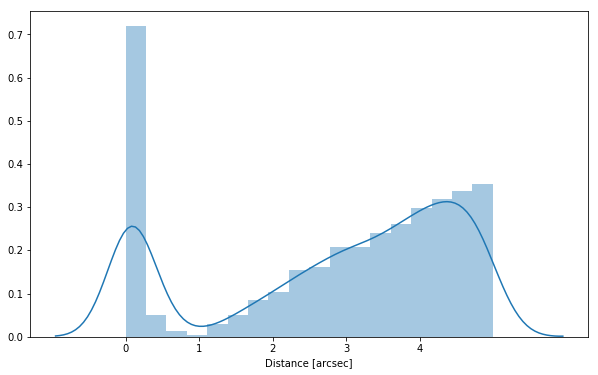

In [8]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(cfhtls_wide['cfhtls-wide_ra'], cfhtls_wide['cfhtls-wide_dec'])
)

In [9]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, 
                                    cfhtls_wide, 
                                    "cfhtls-wide_ra", 
                                    "cfhtls-wide_dec", 
                                    radius=0.8*u.arcsec)

### Add SpARCS

In [10]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(sparcs['sparcs_ra'], sparcs['sparcs_dec'])
)

HELP Warning: There weren't any cross matches. The two surveys probably don't overlap.


In [11]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, sparcs, "sparcs_ra", "sparcs_dec", radius=0.8*u.arcsec)

###  Add CFHT-WIRDS

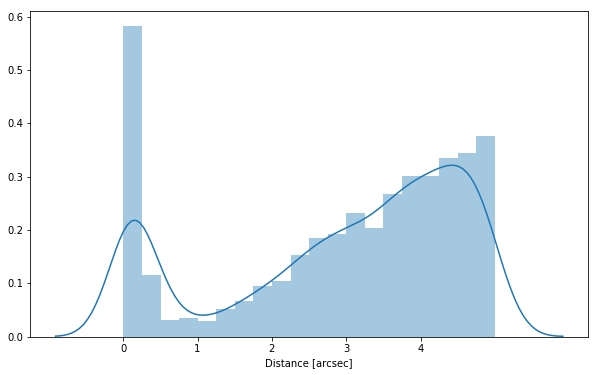

In [12]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(cfht_wirds['wirds_ra'], cfht_wirds['wirds_dec'])
)

In [13]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, 
                                    cfht_wirds, 
                                    "wirds_ra", 
                                    "wirds_dec", 
                                    radius=0.8*u.arcsec)

### Add VIPERS

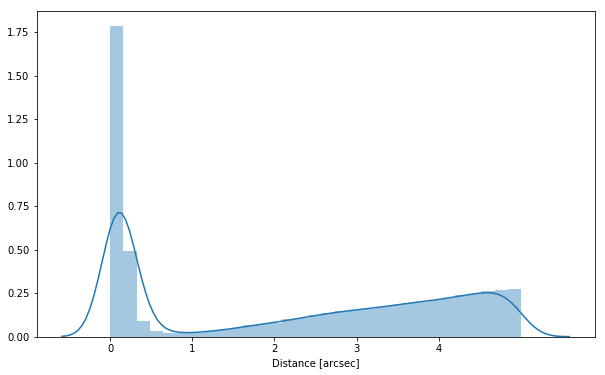

In [14]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(vipers['vipers_ra'], vipers['vipers_dec'])
)

In [15]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, 
                                    vipers, 
                                    "vipers_ra", 
                                    "vipers_dec", 
                                    radius=0.8*u.arcsec)

## Add SXDS

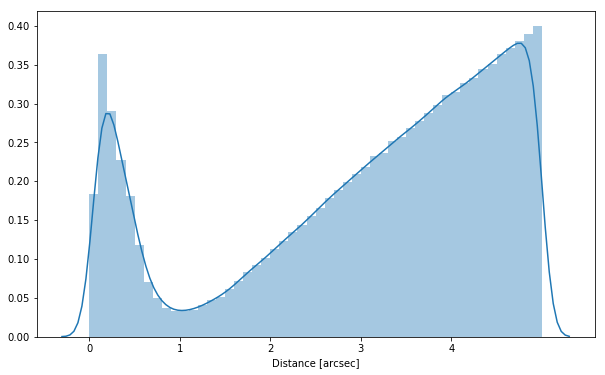

In [16]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(sxds['sxds_ra'], sxds['sxds_dec'])
)

In [17]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, 
                                    sxds, 
                                    "sxds_ra", 
                                    "sxds_dec", 
                                    radius=0.8*u.arcsec)

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [18]:
for col in master_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        master_catalogue[col] = master_catalogue[col].astype(float)
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [19]:
#Since this is not the final merged catalogue. We rename column names to make them unique
master_catalogue['ra'].name = 'cfht_ra'
master_catalogue['dec'].name = 'cfht_dec'
master_catalogue['flag_merged'].name = 'cfht_flag_merged'

In [20]:
master_catalogue[:10].show_in_notebook()

idx,candels_id,cfht_ra,cfht_dec,candels_stellarity,f_acs_f606w,ferr_acs_f606w,f_ap_acs_f606w,ferr_ap_acs_f606w,f_acs_f814w,ferr_acs_f814w,f_ap_acs_f814w,ferr_ap_acs_f814w,f_wfc3_f125w,ferr_wfc3_f125w,f_ap_wfc3_f125w,ferr_ap_wfc3_f125w,f_wfc3_f160w,ferr_wfc3_f160w,f_ap_wfc3_f160w,ferr_ap_wfc3_f160w,f_candels-megacam_u,ferr_candels-megacam_u,f_suprime_b,ferr_suprime_b,f_suprime_v,ferr_suprime_v,f_suprime_rc,ferr_suprime_rc,f_suprime_ip,ferr_suprime_ip,f_suprime_zp,ferr_suprime_zp,f_hawki_k,ferr_hawki_y,ferr_hawki_k,m_acs_f606w,merr_acs_f606w,flag_acs_f606w,m_ap_acs_f606w,merr_ap_acs_f606w,m_acs_f814w,merr_acs_f814w,flag_acs_f814w,m_ap_acs_f814w,merr_ap_acs_f814w,m_wfc3_f125w,merr_wfc3_f125w,flag_wfc3_f125w,m_ap_wfc3_f125w,merr_ap_wfc3_f125w,m_wfc3_f160w,merr_wfc3_f160w,flag_wfc3_f160w,m_ap_wfc3_f160w,merr_ap_wfc3_f160w,m_candels-megacam_u,merr_candels-megacam_u,flag_candels-megacam_u,m_suprime_b,merr_suprime_b,flag_suprime_b,m_suprime_v,merr_suprime_v,flag_suprime_v,m_suprime_rc,merr_suprime_rc,flag_suprime_rc,m_suprime_ip,merr_suprime_ip,flag_suprime_ip,m_suprime_zp,merr_suprime_zp,flag_suprime_zp,m_hawki_k,merr_hawki_k,flag_hawki_k,candels_flag_cleaned,candels_flag_gaia,cfht_flag_merged,cfhtls-deep_id,cfhtls-deep_stellarity,m_cfhtls-deep_u,merr_cfhtls-deep_u,m_cfhtls-deep_g,merr_cfhtls-deep_g,m_cfhtls-deep_r,merr_cfhtls-deep_r,m_cfhtls-deep_i,merr_cfhtls-deep_i,m_cfhtls-deep_z,merr_cfhtls-deep_z,m_cfhtls-deep_y,merr_cfhtls-deep_y,m_ap_cfhtls-deep_u,merr_ap_cfhtls-deep_u,m_ap_cfhtls-deep_g,merr_ap_cfhtls-deep_g,m_ap_cfhtls-deep_r,merr_ap_cfhtls-deep_r,m_ap_cfhtls-deep_i,merr_ap_cfhtls-deep_i,m_ap_cfhtls-deep_z,merr_ap_cfhtls-deep_z,m_ap_cfhtls-deep_y,merr_ap_cfhtls-deep_y,f_cfhtls-deep_u,ferr_cfhtls-deep_u,flag_cfhtls-deep_u,f_cfhtls-deep_g,ferr_cfhtls-deep_g,flag_cfhtls-deep_g,f_cfhtls-deep_r,ferr_cfhtls-deep_r,flag_cfhtls-deep_r,f_cfhtls-deep_i,ferr_cfhtls-deep_i,flag_cfhtls-deep_i,f_cfhtls-deep_z,ferr_cfhtls-deep_z,flag_cfhtls-deep_z,f_cfhtls-deep_y,ferr_cfhtls-deep_y,flag_cfhtls-deep_y,f_ap_cfhtls-deep_u,ferr_ap_cfhtls-deep_u,f_ap_cfhtls-deep_g,ferr_ap_cfhtls-deep_g,f_ap_cfhtls-deep_r,ferr_ap_cfhtls-deep_r,f_ap_cfhtls-deep_i,ferr_ap_cfhtls-deep_i,f_ap_cfhtls-deep_z,ferr_ap_cfhtls-deep_z,f_ap_cfhtls-deep_y,ferr_ap_cfhtls-deep_y,cfhtls-deep_flag_cleaned,cfhtls-deep_flag_gaia,cfhtls-wide_id,cfhtls-wide_stellarity,m_cfhtls-wide_u,merr_cfhtls-wide_u,m_cfhtls-wide_g,merr_cfhtls-wide_g,m_cfhtls-wide_r,merr_cfhtls-wide_r,m_cfhtls-wide_i,merr_cfhtls-wide_i,m_cfhtls-wide_z,merr_cfhtls-wide_z,m_ap_cfhtls-wide_u,merr_ap_cfhtls-wide_u,m_ap_cfhtls-wide_g,merr_ap_cfhtls-wide_g,m_ap_cfhtls-wide_r,merr_ap_cfhtls-wide_r,m_ap_cfhtls-wide_i,merr_ap_cfhtls-wide_i,m_ap_cfhtls-wide_z,merr_ap_cfhtls-wide_z,f_cfhtls-wide_u,ferr_cfhtls-wide_u,flag_cfhtls-wide_u,f_cfhtls-wide_g,ferr_cfhtls-wide_g,flag_cfhtls-wide_g,f_cfhtls-wide_r,ferr_cfhtls-wide_r,flag_cfhtls-wide_r,f_cfhtls-wide_i,ferr_cfhtls-wide_i,flag_cfhtls-wide_i,f_cfhtls-wide_z,ferr_cfhtls-wide_z,flag_cfhtls-wide_z,f_ap_cfhtls-wide_u,ferr_ap_cfhtls-wide_u,f_ap_cfhtls-wide_g,ferr_ap_cfhtls-wide_g,f_ap_cfhtls-wide_r,ferr_ap_cfhtls-wide_r,f_ap_cfhtls-wide_i,ferr_ap_cfhtls-wide_i,f_ap_cfhtls-wide_z,ferr_ap_cfhtls-wide_z,cfhtls-wide_flag_cleaned,cfhtls-wide_flag_gaia,sparcs_intid,sparcs_stellarity,m_ap_sparcs_u,merr_ap_sparcs_u,f_ap_sparcs_u,ferr_ap_sparcs_u,m_sparcs_u,merr_sparcs_u,f_sparcs_u,ferr_sparcs_u,flag_sparcs_u,m_ap_sparcs_g,merr_ap_sparcs_g,f_ap_sparcs_g,ferr_ap_sparcs_g,m_sparcs_g,merr_sparcs_g,f_sparcs_g,ferr_sparcs_g,flag_sparcs_g,m_ap_sparcs_r,merr_ap_sparcs_r,f_ap_sparcs_r,ferr_ap_sparcs_r,m_sparcs_r,merr_sparcs_r,f_sparcs_r,ferr_sparcs_r,flag_sparcs_r,m_ap_sparcs_z,merr_ap_sparcs_z,f_ap_sparcs_z,ferr_ap_sparcs_z,m_sparcs_z,merr_sparcs_z,f_sparcs_z,ferr_sparcs_z,flag_sparcs_z,m_ap_sparcs_y,merr_ap_sparcs_y,f_ap_sparcs_y,ferr_ap_sparcs_y,m_sparcs_y,merr_sparcs_y,f_sparcs_y,ferr_sparcs_y,flag_sparcs_y,sparcs_flag_cleaned,sparcs_flag_gaia,wirds_id,m_wirds_u,merr_wirds_u,m_ap_wirds_u,

In [21]:
master_catalogue.add_column(Column(data=(np.char.array(master_catalogue['cfhtls-wide_id'].astype(str)) 
                                    +  np.char.array(master_catalogue['cfhtls-deep_id'].astype(str) )
                                         +  np.char.array(master_catalogue['candels_id'].astype(str) )
                                    +  np.char.array(master_catalogue['sparcs_intid'].astype(str)) 
                                        +  np.char.array(master_catalogue['wirds_id'].astype(str)) 
                                        +  np.char.array(master_catalogue['vipers_id'].astype(str)) ), 
                              name="cfht_intid"))

In [22]:
id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)

['candels_id', 'cfhtls-deep_id', 'cfhtls-wide_id', 'sparcs_intid', 'wirds_id', 'vipers_id', 'sxds_b_id', 'sxds_v_id', 'sxds_r_id', 'sxds_i_id', 'sxds_z_id', 'sxds_intid', 'cfht_intid']


## VII - Choosing between multiple values for the same filter



### VII.a CFHT Megacam fluxes: CFHTLS-DEEP, CFHTLS-WIDE SpARCS, CANDELS, CFHT-WIRDS and VIPERS

According to Mattia CFHTLenS is built on the same data as CFHTLS-WIDE and should not be included. I have therefore excluded it from the merge above.

CFHTLS-DEEP is prefferred to CFHTLS-WIDE which is prefferred to SpARCS... CANDELS... WIRDS... VIPERS

| Survey (in HELP use order)            | Bands                 | notes |
|:-------------|:------------------|-------------------|
| CFHTLS-DEEP | u, g, r, i, z, y ||
| CFHTLS-WIDE | u, g, r, i, z    ||
| SpARCS      | u, g, r, z, y    ||
| CANDELS     | u                | Total fluxes only |
| CFHT-WIRDS     | u, g, r, i, z  (+ WIRCAM J, H, Ks)            ||
| VIPERS     | u, g, r, i, z, y  (+ WIRCAM Ks)            | Total fluxes only |


In [23]:
megacam_origin = Table()
megacam_origin.add_column(master_catalogue['cfht_intid'])

In [24]:
megacam_stats = Table()
megacam_stats.add_column(Column(data=['u','g','r','i','z','y'], name="Band"))
for col in ["CFHTLS-DEEP", "CFHTLS-WIDE", "SpARCS", "CANDELS", "CFHT-WIRDS", "VIPERS"]:
    megacam_stats.add_column(Column(data=np.full(6, 0), name="{}".format(col)))
    megacam_stats.add_column(Column(data=np.full(6, 0), name="use {}".format(col)))
    megacam_stats.add_column(Column(data=np.full(6, 0), name="{} ap".format(col)))
    megacam_stats.add_column(Column(data=np.full(6, 0), name="use {} ap".format(col)))
    

In [25]:

megacam_bands = ['u','g','r','i','z','y'] # Lowercase naming convention (k is Ks)
for band in megacam_bands:

    # Megacam total flux 
    has_cfhtls_deep = ~np.isnan(master_catalogue['f_cfhtls-deep_' + band])
    if band == 'y':
        has_cfhtls_wide = np.full(len(master_catalogue), False, dtype=bool)
    else:
        has_cfhtls_wide = ~np.isnan(master_catalogue['f_cfhtls-wide_' + band])
        
    if band == 'i':
        has_sparcs = np.full(len(master_catalogue), False, dtype=bool)
    else:
        has_sparcs = ~np.isnan(master_catalogue['f_sparcs_' + band])
        
    if band == 'u':
        has_candels = ~np.isnan(master_catalogue['f_candels-megacam_' + band])
    else:
        has_candels = np.full(len(master_catalogue), False, dtype=bool)
        
    if band == 'y':
        has_wirds = np.full(len(master_catalogue), False, dtype=bool)
    else:
        has_wirds = ~np.isnan(master_catalogue['f_wirds_' + band])
        
    has_vipers  = ~np.isnan(master_catalogue['f_vipers_' + band])
    

    use_cfhtls_deep = has_cfhtls_deep 
    use_cfhtls_wide = has_cfhtls_wide & ~has_cfhtls_deep
    use_sparcs = has_sparcs & ~has_cfhtls_wide & ~has_cfhtls_deep
    use_candels = has_candels & ~has_sparcs & ~has_cfhtls_wide & ~has_cfhtls_deep
    use_wirds = has_wirds & ~has_candels & ~has_sparcs & ~has_cfhtls_wide & ~has_cfhtls_deep
    use_vipers = has_vipers & ~has_wirds & ~has_candels & ~has_sparcs & ~has_cfhtls_wide & ~has_cfhtls_deep

    f_megacam = np.full(len(master_catalogue), np.nan)
    f_megacam[use_cfhtls_deep] = master_catalogue['f_cfhtls-deep_' + band][use_cfhtls_deep]
    if not (band == 'y'):
        f_megacam[use_cfhtls_wide] = master_catalogue['f_cfhtls-wide_' + band][use_cfhtls_wide]
    if not (band == 'i'):
        f_megacam[use_sparcs] = master_catalogue['f_sparcs_' + band][use_sparcs]
    if band == 'u':
        f_megacam[use_candels] = master_catalogue['f_candels-megacam_' + band][use_candels] 
    if not (band == 'y'):
        f_megacam[use_wirds] = master_catalogue['f_wirds_' + band][use_wirds]
    f_megacam[use_vipers] = master_catalogue['f_vipers_' + band][use_vipers]    

    ferr_megacam = np.full(len(master_catalogue), np.nan)
    ferr_megacam[use_cfhtls_deep] = master_catalogue['ferr_cfhtls-deep_' + band][use_cfhtls_deep]
    if not (band == 'y'):
        ferr_megacam[use_cfhtls_wide] = master_catalogue['ferr_cfhtls-wide_' + band][use_cfhtls_wide]
    if not (band == 'i'):
        ferr_megacam[use_sparcs] = master_catalogue['ferr_sparcs_' + band][use_sparcs]
    if band == 'u':
        ferr_megacam[use_candels] = master_catalogue['ferr_candels-megacam_' + band][use_candels]
    if not (band == 'y'):
        ferr_megacam[use_wirds] = master_catalogue['ferr_wirds_' + band][use_wirds]
    ferr_megacam[use_vipers] = master_catalogue['ferr_vipers_' + band][use_vipers] 
    
    m_megacam = np.full(len(master_catalogue), np.nan)
    m_megacam[use_cfhtls_deep] = master_catalogue['m_cfhtls-deep_' + band][use_cfhtls_deep]
    if not (band == 'y'):
        m_megacam[use_cfhtls_wide] = master_catalogue['m_cfhtls-wide_' + band][use_cfhtls_wide]
    if not (band == 'i'):
        m_megacam[use_sparcs] = master_catalogue['m_sparcs_' + band][use_sparcs]
    if band == 'u':
        m_megacam[use_candels] = master_catalogue['m_candels-megacam_' + band][use_candels]
    if not (band == 'y'):
        m_megacam[use_wirds] = master_catalogue['m_wirds_' + band][use_wirds]
    m_megacam[use_vipers] = master_catalogue['m_vipers_' + band][use_vipers] 

    merr_megacam = np.full(len(master_catalogue), np.nan)
    merr_megacam[use_cfhtls_deep] = master_catalogue['merr_cfhtls-deep_' + band][use_cfhtls_deep]
    if not (band == 'y'):
        merr_megacam[use_cfhtls_wide] = master_catalogue['merr_cfhtls-wide_' + band][use_cfhtls_wide]
    if not (band == 'i'):
        merr_megacam[use_sparcs] = master_catalogue['merr_sparcs_' + band][use_sparcs]
    if band == 'u':
        merr_megacam[use_candels] = master_catalogue['merr_candels-megacam_' + band][use_candels]
    if not (band == 'y'):
        merr_megacam[use_wirds] = master_catalogue['merr_wirds_' + band][use_wirds]
    merr_megacam[use_vipers] = master_catalogue['merr_vipers_' + band][use_vipers] 

    flag_megacam = np.full(len(master_catalogue), False, dtype=bool)
    flag_megacam[use_cfhtls_deep] = master_catalogue['flag_cfhtls-deep_' + band][use_cfhtls_deep]
    if not (band == 'y'):
        flag_megacam[use_cfhtls_wide] = master_catalogue['flag_cfhtls-wide_' + band][use_cfhtls_wide]
    if not (band == 'i'):
        flag_megacam[use_sparcs] = master_catalogue['flag_sparcs_' + band][use_sparcs]
    if band == 'u':
        flag_megacam[use_candels] = master_catalogue['flag_candels-megacam_' + band][use_candels]
    if not (band == 'y'):
        flag_megacam[use_wirds] = master_catalogue['flag_wirds_' + band][use_wirds]
    flag_megacam[use_vipers] = master_catalogue['flag_vipers_' + band][use_vipers] 

    master_catalogue.add_column(Column(data=f_megacam, name="f_megacam_" + band))
    master_catalogue.add_column(Column(data=ferr_megacam, name="ferr_megacam_" + band))
    master_catalogue.add_column(Column(data=m_megacam, name="m_megacam_" + band))
    master_catalogue.add_column(Column(data=merr_megacam, name="merr_megacam_" + band))
    master_catalogue.add_column(Column(data=flag_megacam, name="flag_megacam_" + band))

    
    old_columns = []
    column_types = ['f', 'ferr', 'm', 'merr', 'flag'] 
    for col_t in column_types:
        old_columns += ['{}_cfhtls-deep_{}'.format(col_t, band)]
        if not (band == 'y'):
            old_columns += ['{}_cfhtls-wide_{}'.format(col_t, band)]
        if not (band == 'i'):
            old_columns += ['{}_sparcs_{}'.format(col_t, band)]    
        if band == 'u':
            old_columns += ['{}_candels-megacam_{}'.format(col_t, band)] 
        if not (band == 'y'):
            old_columns += ['{}_wirds_{}'.format(col_t, band)] 
        old_columns += ['{}_vipers_{}'.format(col_t, band)]     
        
    master_catalogue.remove_columns(old_columns)

    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_cfhtls_deep] = "CFHTLS-DEEP"
    origin[use_cfhtls_wide] = "CFHTLS-WIDE"
    origin[use_sparcs] = "SpARCS"
    origin[use_candels] = "CANDELS"
    origin[use_wirds] = "WIRDS"
    origin[use_vipers] = "VIPERS"
    
    megacam_origin.add_column(Column(data=origin, name= 'f_megacam_' + band ))
    
    # Megacam aperture flux 
    has_ap_cfhtls_deep = ~np.isnan(master_catalogue['f_ap_cfhtls-deep_' + band])
    if band == 'y':
        has_ap_cfhtls_wide = np.full(len(master_catalogue), False, dtype=bool)
    else:
        has_ap_cfhtls_wide = ~np.isnan(master_catalogue['f_ap_cfhtls-wide_' + band])
    if band == 'i':
        has_ap_sparcs = np.full(len(master_catalogue), False, dtype=bool)
    else:
        has_ap_sparcs = ~np.isnan(master_catalogue['f_ap_sparcs_' + band])
    if not (band == 'y'):
        has_ap_wirds = ~np.isnan(master_catalogue['f_ap_wirds_' + band])
    else:
        has_ap_wirds = np.full(len(master_catalogue), False, dtype=bool)
    

    use_ap_cfhtls_deep = has_ap_cfhtls_deep 
    use_ap_cfhtls_wide = has_ap_cfhtls_wide & ~has_ap_cfhtls_deep
    use_ap_sparcs = has_ap_sparcs & ~has_ap_cfhtls_wide & ~has_ap_cfhtls_deep
    use_ap_wirds = has_ap_wirds & ~has_ap_sparcs & ~has_ap_cfhtls_wide & ~has_ap_cfhtls_deep

    f_ap_megacam = np.full(len(master_catalogue), np.nan)
    f_ap_megacam[use_ap_cfhtls_deep] = master_catalogue['f_ap_cfhtls-deep_' + band][use_ap_cfhtls_deep]
    if not (band == 'y'):
        f_ap_megacam[use_ap_cfhtls_wide] = master_catalogue['f_ap_cfhtls-wide_' + band][use_ap_cfhtls_wide]
    if not (band == 'i'):
        f_ap_megacam[use_ap_sparcs] = master_catalogue['f_ap_sparcs_' + band][use_ap_sparcs]
    if not (band == 'y'):
        f_ap_megacam[use_ap_wirds] = master_catalogue['f_ap_wirds_' + band][use_ap_wirds]
        
    ferr_ap_megacam = np.full(len(master_catalogue), np.nan)
    ferr_ap_megacam[use_ap_cfhtls_deep] = master_catalogue['ferr_ap_cfhtls-deep_' + band][use_ap_cfhtls_deep]
    if not (band == 'y'):
        ferr_ap_megacam[use_ap_cfhtls_wide] = master_catalogue['ferr_ap_cfhtls-wide_' + band][use_ap_cfhtls_wide]
    if not (band == 'i'):
        ferr_ap_megacam[use_ap_sparcs] = master_catalogue['ferr_ap_sparcs_' + band][use_ap_sparcs]
    if not (band == 'y'):
        ferr_ap_megacam[use_ap_wirds] = master_catalogue['ferr_ap_wirds_' + band][use_ap_wirds]
    
    m_ap_megacam = np.full(len(master_catalogue), np.nan)
    m_ap_megacam[use_ap_cfhtls_deep] = master_catalogue['m_ap_cfhtls-deep_' + band][use_ap_cfhtls_deep]
    if not (band == 'y'):
        m_ap_megacam[use_ap_cfhtls_wide] = master_catalogue['m_ap_cfhtls-wide_' + band][use_ap_cfhtls_wide]
    if not (band == 'i'):
        m_ap_megacam[use_ap_sparcs] = master_catalogue['m_ap_sparcs_' + band][use_ap_sparcs]
    if not (band == 'y'):
        m_ap_megacam[use_ap_wirds] = master_catalogue['m_ap_wirds_' + band][use_ap_wirds]

    merr_ap_megacam = np.full(len(master_catalogue), np.nan)
    merr_ap_megacam[use_ap_cfhtls_deep] = master_catalogue['merr_ap_cfhtls-deep_' + band][use_ap_cfhtls_deep]
    if not (band == 'y'):
        merr_ap_megacam[use_ap_cfhtls_wide] = master_catalogue['merr_ap_cfhtls-wide_' + band][use_ap_cfhtls_wide]
    if not (band == 'i'):
        merr_ap_megacam[use_ap_sparcs] = master_catalogue['merr_ap_sparcs_' + band][use_ap_sparcs]
    if not (band == 'y'):
        merr_ap_megacam[use_ap_wirds] = master_catalogue['merr_ap_wirds_' + band][use_ap_wirds]



    master_catalogue.add_column(Column(data=f_ap_megacam, name="f_ap_megacam_" + band))
    master_catalogue.add_column(Column(data=ferr_ap_megacam, name="ferr_ap_megacam_" + band))
    master_catalogue.add_column(Column(data=m_ap_megacam, name="m_ap_megacam_" + band))
    master_catalogue.add_column(Column(data=merr_ap_megacam, name="merr_ap_megacam_" + band))


    
    old_ap_columns = []
    column_types = ['f', 'ferr', 'm', 'merr'] 
    for col_t in column_types:
        old_ap_columns += ['{}_ap_cfhtls-deep_{}'.format(col_t, band)]
        if not (band == 'y'):
            old_ap_columns += ['{}_ap_cfhtls-wide_{}'.format(col_t, band)]
        if not (band == 'i'):
            old_ap_columns += ['{}_ap_sparcs_{}'.format(col_t, band)]    
        if not (band == 'y'):
            old_ap_columns += ['{}_ap_wirds_{}'.format(col_t, band)] 
    
        
    master_catalogue.remove_columns(old_ap_columns)

    origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin_ap[use_ap_cfhtls_deep] = "CFHTLS-DEEP"
    origin_ap[use_ap_cfhtls_wide] = "CFHTLS-WIDE"
    origin_ap[use_ap_sparcs] = "SpARCS"
    origin_ap[use_ap_wirds] = "CFHT-WIRDS"
    
    megacam_origin.add_column(Column(data=origin_ap, name= 'f_ap_megacam_' + band ))
    

   
    megacam_stats['CFHTLS-DEEP'][megacam_stats['Band'] == band] = np.sum(has_cfhtls_deep)
    megacam_stats['CFHTLS-WIDE'][megacam_stats['Band'] == band] = np.sum(has_cfhtls_wide)
    megacam_stats['SpARCS'][megacam_stats['Band'] == band] = np.sum(has_sparcs)
    megacam_stats['CANDELS'][megacam_stats['Band'] == band] = np.sum(has_candels)
    megacam_stats['CFHT-WIRDS'][megacam_stats['Band'] == band] = np.sum(has_wirds)
    megacam_stats['VIPERS'][megacam_stats['Band'] == band] = np.sum(has_vipers)
    megacam_stats['use CFHTLS-DEEP'][megacam_stats['Band'] == band] = np.sum(use_cfhtls_deep)
    megacam_stats['use CFHTLS-WIDE'][megacam_stats['Band'] == band] = np.sum(use_cfhtls_wide)
    megacam_stats['use SpARCS'][megacam_stats['Band'] == band] = np.sum(use_sparcs)
    megacam_stats['use CANDELS'][megacam_stats['Band'] == band] = np.sum(use_candels)
    megacam_stats['use CFHT-WIRDS'][megacam_stats['Band'] == band] = np.sum(use_wirds)
    megacam_stats['use VIPERS'][megacam_stats['Band'] == band] = np.sum(use_vipers)
    
    megacam_stats['CFHTLS-DEEP ap'][megacam_stats['Band'] == band] = np.sum(has_ap_cfhtls_deep)
    megacam_stats['CFHTLS-WIDE ap'][megacam_stats['Band'] == band] = np.sum(has_ap_cfhtls_wide)
    megacam_stats['SpARCS ap'][megacam_stats['Band'] == band] = np.sum(has_ap_sparcs)
    megacam_stats['CFHT-WIRDS ap'][megacam_stats['Band'] == band] = np.sum(has_ap_wirds)
    megacam_stats['use CFHTLS-DEEP ap'][megacam_stats['Band'] == band] = np.sum(use_ap_cfhtls_deep)
    megacam_stats['use CFHTLS-WIDE ap'][megacam_stats['Band'] == band] = np.sum(use_ap_cfhtls_wide)
    megacam_stats['use SpARCS ap'][megacam_stats['Band'] == band] = np.sum(use_ap_sparcs)
    megacam_stats['use CFHT-WIRDS ap'][megacam_stats['Band'] == band] = np.sum(use_ap_wirds)

In [26]:
megacam_stats.show_in_notebook()

idx,Band,CFHTLS-DEEP,use CFHTLS-DEEP,CFHTLS-DEEP ap,use CFHTLS-DEEP ap,CFHTLS-WIDE,use CFHTLS-WIDE,CFHTLS-WIDE ap,use CFHTLS-WIDE ap,SpARCS,use SpARCS,SpARCS ap,use SpARCS ap,CANDELS,use CANDELS,CANDELS ap,use CANDELS ap,CFHT-WIRDS,use CFHT-WIRDS,CFHT-WIRDS ap,use CFHT-WIRDS ap,VIPERS,use VIPERS,VIPERS ap,use VIPERS ap
0,u,2630,2630,2641,2641,1228,189,1247,194,4290,4290,4152,4152,35931,35931,0,0,134630,133723,135091,134173,908447,869492,0,0
1,g,3051,3051,3037,3037,1347,194,1357,195,4550,4550,4472,4472,0,0,0,0,143047,142075,142074,141095,945986,910640,0,0
2,r,3130,3130,3135,3135,1350,197,1355,200,4852,4852,4808,4808,0,0,0,0,144102,143120,143184,142198,949549,914214,0,0
3,i,3123,3123,3126,3126,1319,194,1328,195,0,0,0,0,0,0,0,0,144330,143350,143316,142331,728690,704905,0,0
4,z,2779,2779,2811,2811,1158,179,1206,186,4423,4423,4144,4144,0,0,0,0,141308,140349,141154,140184,922753,887609,0,0
5,y,2913,2913,2928,2928,0,0,0,0,4559,4559,4404,4404,0,0,0,0,0,0,0,0,221194,221194,0,0


In [27]:
megacam_origin.write("{}/xmm-lss_megacam_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

### VII.b CFHT WIRCAM fluxes: CFHT-WIRDS and VIPERS

We take WIRDS over VIPERS

In [28]:
for col in master_catalogue.colnames:
    if '_wirds_j' in col:
        master_catalogue.rename_column(col, col.replace('_wirds_j', '_wircam_j'))
    if '_wirds_h' in col:
        master_catalogue.rename_column(col, col.replace('_wirds_h', '_wircam_h'))
    if '_wirds_k' in col:
        master_catalogue.rename_column(col, col.replace('_wirds_k', '_wircam_ks'))

In [29]:
has_wirds = ~np.isnan(master_catalogue['f_wircam_ks' ])
has_vipers = ~np.isnan(master_catalogue['f_vipers_ks' ])

use_wirds = has_wirds
use_vipers = has_vipers & ~has_wirds

master_catalogue['f_wircam_ks'][use_vipers] = master_catalogue['f_vipers_ks'][use_vipers]
master_catalogue['ferr_wircam_ks'][use_vipers] = master_catalogue['ferr_vipers_ks'][use_vipers]
master_catalogue['m_wircam_ks'][use_vipers] = master_catalogue['m_vipers_ks'][use_vipers]
master_catalogue['merr_wircam_ks'][use_vipers] = master_catalogue['merr_vipers_ks'][use_vipers]
master_catalogue['flag_wircam_ks'][use_vipers] = master_catalogue['flag_vipers_ks'][use_vipers]

master_catalogue.remove_columns(['f_vipers_ks', 'ferr_vipers_ks', 'm_vipers_ks', 'merr_vipers_ks', 'flag_vipers_ks'])




In [30]:
print('There are {} objects with WIRDS Ks fluxes and {} with VIPERS Ks.'.format(np.sum(has_wirds), np.sum(has_vipers)))
print('We use all {} Ks fluxes and take the remaining {} VIPERS Ks fluxes.'.format(np.sum(use_wirds), np.sum(use_vipers)))

There are 157497 objects with WIRDS Ks fluxes and 644584 with VIPERS Ks.
We use all 157497 Ks fluxes and take the remaining 644511 VIPERS Ks fluxes.


In [31]:
wircam_origin = Table()
wircam_origin.add_column(master_catalogue['cfht_intid'])
origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_wirds] = "CFHT-WIRDS"
origin[use_vipers] = "VIPERS"
wircam_origin.add_column(Column(data=origin, name= 'f_wircam_ks'  ))
wircam_origin.write("{}/xmm-lss_wircam_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

### VII.c Subaru SuprimeCam fluxes: SXDS and CANDELS-UDS

We take SXDS over CANDELS so that there are not objects with total and ap mags from different source.

In [32]:
suprime_origin = Table()
suprime_origin.add_column(master_catalogue['cfht_intid'])

In [33]:
suprime_stats = Table()
suprime_bands = ['b', 'v', 'rc', 'ip', 'zp']
suprime_stats.add_column(Column(data=suprime_bands, name="Band"))
for col in ["SXDS", "CANDELS-UDS"]:
    suprime_stats.add_column(Column(data=np.full(5, 0), name="{}".format(col)))
    suprime_stats.add_column(Column(data=np.full(5, 0), name="use {}".format(col)))
    suprime_stats.add_column(Column(data=np.full(5, 0), name="{} ap".format(col)))
    suprime_stats.add_column(Column(data=np.full(5, 0), name="use {} ap".format(col)))

In [34]:
suprime_bands = ['b', 'v', 'rc', 'ip', 'zp']
for band in suprime_bands:

    # SuprimeCam total flux 
    has_candels = ~np.isnan(master_catalogue['f_suprime_' + band])
    has_sxds = ~np.isnan(master_catalogue['f_sxds-suprime_' + band])

     
    use_sxds = has_sxds 
    use_candels = has_candels & ~has_sxds


    f_suprime = np.full(len(master_catalogue), np.nan)
    f_suprime[use_candels] = master_catalogue['f_suprime_' + band][use_candels]
    f_suprime[use_sxds] = master_catalogue['f_sxds-suprime_' + band][use_sxds]

    ferr_suprime = np.full(len(master_catalogue), np.nan)
    ferr_suprime[use_candels] = master_catalogue['ferr_suprime_' + band][use_candels]
    ferr_suprime[use_sxds] = master_catalogue['ferr_sxds-suprime_' + band][use_sxds]
    
    m_suprime = np.full(len(master_catalogue), np.nan)
    m_suprime[use_candels] = master_catalogue['m_suprime_' + band][use_candels]
    m_suprime[use_sxds] = master_catalogue['m_sxds-suprime_' + band][use_sxds]
    
    merr_suprime = np.full(len(master_catalogue), np.nan)
    merr_suprime[use_candels] = master_catalogue['merr_suprime_' + band][use_candels]
    merr_suprime[use_sxds] = master_catalogue['merr_sxds-suprime_' + band][use_sxds]
    
    flag_suprime = np.full(len(master_catalogue), False, dtype=bool)
    flag_suprime[use_candels] = master_catalogue['flag_suprime_' + band][use_candels]
    flag_suprime[use_sxds] = master_catalogue['flag_sxds-suprime_' + band][use_sxds]

    master_catalogue["f_suprime_" + band][use_sxds] = master_catalogue["f_sxds-suprime_" + band][use_sxds]
    master_catalogue["ferr_suprime_" + band][use_sxds] = master_catalogue["ferr_sxds-suprime_" + band][use_sxds]
    master_catalogue["m_suprime_" + band][use_sxds] = master_catalogue["m_sxds-suprime_" + band][use_sxds]
    master_catalogue["merr_suprime_" + band][use_sxds] = master_catalogue["merr_sxds-suprime_" + band][use_sxds]
    master_catalogue["flag_suprime_" + band][use_sxds] = master_catalogue["flag_sxds-suprime_" + band][use_sxds]


    old_sxds_columns =      ['f_sxds-suprime_' + band,
                               'ferr_sxds-suprime_' + band,
                               'm_sxds-suprime_' + band, 
                               'merr_sxds-suprime_' + band,
                               'flag_sxds-suprime_' + band]
    

    master_catalogue.remove_columns(old_sxds_columns)

    origin = np.full(len(master_catalogue), '     ', dtype='<U7')
    origin[use_candels] = "CANDELS"
    origin[use_sxds] = "SXDS"

    
    suprime_origin.add_column(Column(data=origin, name= 'f_suprime_' + band ))
        

   
    suprime_stats['CANDELS-UDS'][suprime_stats['Band'] == band] = np.sum(has_candels)
    suprime_stats['SXDS'][suprime_stats['Band'] == band] = np.sum(has_sxds)

    suprime_stats['use CANDELS-UDS'][suprime_stats['Band'] == band] = np.sum(use_candels)
    suprime_stats['use SXDS'][suprime_stats['Band'] == band] = np.sum(use_sxds)
    
    suprime_stats['CANDELS-UDS ap'][suprime_stats['Band'] == band] = 0
    has_ap_sxds = np.sum( ~np.isnan(master_catalogue['f_ap_sxds-suprime_' + band]))
    suprime_stats['SXDS ap'][suprime_stats['Band'] == band] = has_ap_sxds

    suprime_stats['use CANDELS-UDS ap'][suprime_stats['Band'] == band] = 0
    suprime_stats['use SXDS ap'][suprime_stats['Band'] == band] = has_ap_sxds
    



In [37]:
#Aperture fluxes all from SXDS
for col in master_catalogue.colnames:
    if '_ap_sxds-suprime_' in col:
        master_catalogue.rename_column(col, col.replace('_ap_sxds-suprime_', '_ap_suprime_'))

In [38]:
suprime_stats.show_in_notebook()

idx,Band,SXDS,use SXDS,SXDS ap,use SXDS ap,CANDELS-UDS,use CANDELS-UDS,CANDELS-UDS ap,use CANDELS-UDS ap
0,b,906583,906583,883356,883356,35617,9695,0,0
1,v,962920,962920,929149,929149,35617,9113,0,0
2,rc,865240,865240,842174,842174,35617,9738,0,0
3,ip,862147,862147,845760,845760,35617,9725,0,0
4,zp,811731,811731,772020,772020,35617,12293,0,0


In [39]:
suprime_origin.write("{}/xmm-lss_suprime_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

In [ ]:
master_catalogue[:10].show_in_notebook()

idx,candels_id,cfht_ra,cfht_dec,candels_stellarity,f_acs_f606w,ferr_acs_f606w,f_ap_acs_f606w,ferr_ap_acs_f606w,f_acs_f814w,ferr_acs_f814w,f_ap_acs_f814w,ferr_ap_acs_f814w,f_wfc3_f125w,ferr_wfc3_f125w,f_ap_wfc3_f125w,ferr_ap_wfc3_f125w,f_wfc3_f160w,ferr_wfc3_f160w,f_ap_wfc3_f160w,ferr_ap_wfc3_f160w,f_suprime_b,ferr_suprime_b,f_suprime_v,ferr_suprime_v,f_suprime_rc,ferr_suprime_rc,f_suprime_ip,ferr_suprime_ip,f_suprime_zp,ferr_suprime_zp,f_hawki_k,ferr_hawki_y,ferr_hawki_k,m_acs_f606w,merr_acs_f606w,flag_acs_f606w,m_ap_acs_f606w,merr_ap_acs_f606w,m_acs_f814w,merr_acs_f814w,flag_acs_f814w,m_ap_acs_f814w,merr_ap_acs_f814w,m_wfc3_f125w,merr_wfc3_f125w,flag_wfc3_f125w,m_ap_wfc3_f125w,merr_ap_wfc3_f125w,m_wfc3_f160w,merr_wfc3_f160w,flag_wfc3_f160w,m_ap_wfc3_f160w,merr_ap_wfc3_f160w,m_suprime_b,merr_suprime_b,flag_suprime_b,m_suprime_v,merr_suprime_v,flag_suprime_v,m_suprime_rc,merr_suprime_rc,flag_suprime_rc,m_suprime_ip,merr_suprime_ip,flag_suprime_ip,m_suprime_zp,merr_suprime_zp,flag_suprime_zp,m_hawki_k,merr_hawki_k,flag_hawki_k,candels_flag_cleaned,candels_flag_gaia,cfht_flag_merged,cfhtls-deep_id,cfhtls-deep_stellarity,cfhtls-deep_flag_cleaned,cfhtls-deep_flag_gaia,cfhtls-wide_id,cfhtls-wide_stellarity,cfhtls-wide_flag_cleaned,cfhtls-wide_flag_gaia,sparcs_intid,sparcs_stellarity,sparcs_flag_cleaned,sparcs_flag_gaia,wirds_id,m_wircam_j,merr_wircam_j,m_ap_wircam_j,merr_ap_wircam_j,m_wircam_h,merr_wircam_h,m_ap_wircam_h,merr_ap_wircam_h,m_wircam_ks,merr_wircam_ks,m_ap_wircam_ks,merr_ap_wircam_ks,f_wircam_j,ferr_wircam_j,flag_wircam_j,f_ap_wircam_j,ferr_ap_wircam_j,f_wircam_h,ferr_wircam_h,flag_wircam_h,f_ap_wircam_h,ferr_ap_wircam_h,f_wircam_ks,ferr_wircam_ks,flag_wircam_ks,f_ap_wircam_ks,ferr_ap_wircam_ks,wirds_flag_cleaned,cfht-wirds_flag_gaia,vipers_id,vipers_flag_cleaned,vipers_flag_gaia,sxds_b_id,m_ap_suprime_b,merr_ap_suprime_b,sxds_flag_merged,sxds_v_id,m_ap_suprime_v,merr_ap_suprime_v,sxds_r_id,m_ap_suprime_rc,merr_ap_suprime_rc,sxds_i_id,m_ap_suprime_ip,merr_ap_suprime_ip,sxds_z_id,m_ap_suprime_zp,merr_ap_suprime_zp,f_ap_suprime_b,ferr_ap_suprime_b,f_ap_suprime_v,ferr_ap_suprime_v,f_ap_suprime_rc,ferr_ap_suprime_rc,f_ap_suprime_ip,ferr_ap_suprime_ip,f_ap_suprime_zp,ferr_ap_suprime_zp,sxds_stellarity,sxds_flag_cleaned,sxds_flag_gaia,sxds_intid,cfht_intid,f_megacam_u,ferr_megacam_u,m_megacam_u,merr_megacam_u,flag_megacam_u,f_ap_megacam_u,ferr_ap_megacam_u,m_ap_megacam_u,merr_ap_megacam_u,f_megacam_g,ferr_megacam_g,m_megacam_g,merr_megacam_g,flag_megacam_g,f_ap_megacam_g,ferr_ap_megacam_g,m_ap_megacam_g,merr_ap_megacam_g,f_megacam_r,ferr_megacam_r,m_megacam_r,merr_megacam_r,flag_megacam_r,f_ap_megacam_r,ferr_ap_megacam_r,m_ap_megacam_r,merr_ap_megacam_r,f_megacam_i,ferr_megacam_i,m_megacam_i,merr_megacam_i,flag_megacam_i,f_ap_megacam_i,ferr_ap_megacam_i,m_ap_megacam_i,merr_ap_megacam_i,f_megacam_z,ferr_megacam_z,m_megacam_z,merr_megacam_z,flag_megacam_z,f_ap_megacam_z,ferr_ap_megacam_z,m_ap_megacam_z,merr_ap_megacam_z,f_megacam_y,ferr_megacam_y,m_megacam_y,merr_megacam_y,flag_megacam_y,f_ap_megacam_y,ferr_ap_megacam_y,m_ap_megacam_y,merr_ap_megacam_y
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,35489,34.4574665693,-5.12505315973,0.810000002384,0.298381,0.0238874,10.9281,0.15288,0.00143149,0.0092305,-0.00183649,0.0642266,nan,nan,nan,nan,nan,nan,0.141817,0.122139,0.0004968,0.0005385,0.0005475,0.0006726,-0.0006306,0.0009151,0.0004952,0.0008751,-0.0030324,0.0022392,nan,-99.0,nan,25.2130720872,0.0869204641634,False,21.3036383488,0.0151890402708,31.0105292037,7.00101854573,False,nan,-37.9708819152,nan,nan,False,nan,nan,nan,nan,False,26.0206792648,0.935083483031,32.1595460321,1.17686985963,False,32.0540396912,1.333819491,False,nan,-1.57557437516,False,32.16304841,1.91867478349,False,nan,-0.80173476774,False,nan,nan,False,False,0,False,-1,nan,False,0,-1,nan,False,0,-1,

## XI - Saving the catalogue

In [ ]:
master_catalogue.write("{}/cfht_merged_catalogue_xmm-lss.fits".format(TMP_DIR), overwrite=True)